原始数据点:
天数: [   30    60    91   182   365   730  1095  1825  2555  3650  7300 10950]
BEY收益率: [0.0532 0.0535 0.054  0.0545 0.0525 0.0485 0.046  0.0435 0.0425 0.0415
 0.0455 0.0465]

插值结果示例:
天数		BEY		APY		连续复利
45		0.0533		0.0540		0.0526
100		0.0541		0.0549		0.0534
500		0.0508		0.0514		0.0501
1000		0.0465		0.0471		0.0460
5000		0.0422		0.0426		0.0417

样条系数示例（前3个区间）:
区间 [30, 60] 天:
  系数: a=0.053200, b=0.000008, c=0.000000, d=0.000000
  左端点: 0.053200 (应为: 0.053200)
  右端点: 0.053500 (应为: 0.053500)
区间 [60, 91] 天:
  系数: a=0.053500, b=0.000014, c=0.000000, d=-0.000000
  左端点: 0.053500 (应为: 0.053500)
  右端点: 0.054000 (应为: 0.054000)
区间 [91, 182] 天:
  系数: a=0.054000, b=0.000015, c=-0.000000, d=0.000000
  左端点: 0.054000 (应为: 0.054000)
  右端点: 0.054500 (应为: 0.054500)


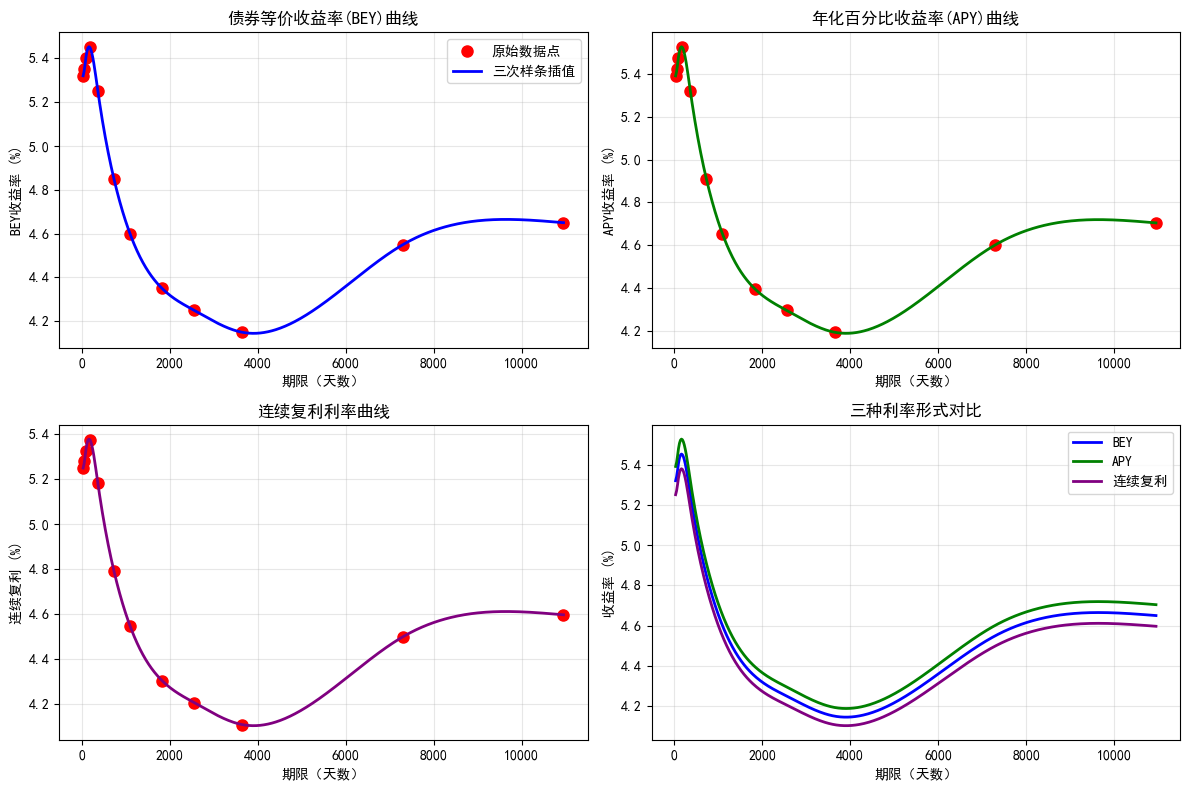


导数连续性验证:
节点 60 天: 左导数=0.00001366, 右导数=0.00001366, 差值=0.00e+00
节点 91 天: 左导数=0.00001539, 右导数=0.00001539, 差值=0.00e+00
节点 182 天: 左导数=-0.00000274, 右导数=-0.00000274, 差值=0.00e+00
节点 365 天: 左导数=-0.00001408, 右导数=-0.00001408, 差值=0.00e+00
节点 730 天: 左导数=-0.00000849, 右导数=-0.00000849, 差值=0.00e+00
节点 1095 天: 左导数=-0.00000541, 右导数=-0.00000541, 差值=0.00e+00
节点 1825 天: 左导数=-0.00000197, 右导数=-0.00000197, 差值=0.00e+00
节点 2555 天: 左导数=-0.00000112, 右导数=-0.00000112, 差值=0.00e+00
节点 3650 天: 左导数=-0.00000038, 右导数=-0.00000038, 差值=0.00e+00
节点 7300 天: 左导数=0.00000117, 右导数=0.00000117, 差值=0.00e+00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import math
# 示例数据：美国国债收益率曲线（2024年1月示例数据）
# 期限（天数）和对应的债券等价收益率（BEY，单位：%）

plt.rcParams['font.sans-serif'] = 'SimHei'

maturity_days = np.array([30, 60, 91, 182, 365, 730, 1095, 1825, 2555, 3650, 7300, 10950])
bey_rates = np.array([5.32, 5.35, 5.40, 5.45, 5.25, 4.85, 4.60, 4.35, 4.25, 4.15, 4.55, 4.65]) / 100  # 转换为小数

print("原始数据点:")
print("天数:", maturity_days)
print("BEY收益率:", bey_rates)

# 1. 创建自然三次样条插值函数
# bc_type='natural' 表示自然边界条件（二阶导数为0）
cs = CubicSpline(maturity_days, bey_rates, bc_type='natural')

# 2. 在更密集的点上进行插值用于绘图
interp_days = np.linspace(30, 10950, 500)
interp_bey = cs(interp_days)

# 3. 转换函数：BEY → APY → 连续复利
def bey_to_apy(bey):
    """债券等价收益率(BEY)转年化百分比收益率(APY)"""
    return (1 + bey/2)**2 - 1

def apy_to_continuous(apy):
    """APY转连续复利利率"""
    return math.log(1 + apy)

# 向量化转换函数
bey_to_apy_vec = np.vectorize(bey_to_apy)
apy_to_continuous_vec = np.vectorize(apy_to_continuous)

# 4. 计算转换后的利率
interp_apy = bey_to_apy_vec(interp_bey)
interp_continuous = apy_to_continuous_vec(interp_apy)

# 5. 计算特定天数的示例
example_days = [45, 100, 500, 1000, 5000]
example_bey = cs(example_days)
example_apy = bey_to_apy_vec(example_bey)
example_continuous = apy_to_continuous_vec(example_apy)

print("\n插值结果示例:")
print("天数\t\tBEY\t\tAPY\t\t连续复利")
for i in range(len(example_days)):
    print(f"{example_days[i]}\t\t{example_bey[i]:.4f}\t\t{example_apy[i]:.4f}\t\t{example_continuous[i]:.4f}")

# 6. 获取样条系数（展示分段插值的原理）
print("\n样条系数示例（前3个区间）:")
for i in range(min(3, len(maturity_days)-1)):
    coeffs = cs.c[:, i]  # 第i个区间的系数 [d, c, b, a]
    print(f"区间 [{maturity_days[i]}, {maturity_days[i+1]}] 天:")
    print(f"  系数: a={coeffs[3]:.6f}, b={coeffs[2]:.6f}, c={coeffs[1]:.6f}, d={coeffs[0]:.6f}")
    
    # 验证端点连续性
    t_left = maturity_days[i]
    t_right = maturity_days[i+1]
    left_val = coeffs[3] + coeffs[2]*(t_left-t_left) + coeffs[1]*(t_left-t_left)**2 + coeffs[0]*(t_left-t_left)**3
    right_val = coeffs[3] + coeffs[2]*(t_right-t_left) + coeffs[1]*(t_right-t_left)**2 + coeffs[0]*(t_right-t_left)**3
    print(f"  左端点: {left_val:.6f} (应为: {bey_rates[i]:.6f})")
    print(f"  右端点: {right_val:.6f} (应为: {bey_rates[i+1]:.6f})")

# 7. 绘图展示结果
plt.figure(figsize=(12, 8))

# 子图1: BEY收益率曲线
plt.subplot(2, 2, 1)
plt.plot(maturity_days, bey_rates * 100, 'ro', label='原始数据点', markersize=8)
plt.plot(interp_days, interp_bey * 100, 'b-', label='三次样条插值', linewidth=2)
plt.xlabel('期限（天数）')
plt.ylabel('BEY收益率 (%)')
plt.title('债券等价收益率(BEY)曲线')
plt.grid(True, alpha=0.3)
plt.legend()

# 子图2: APY收益率曲线
plt.subplot(2, 2, 2)
plt.plot(maturity_days, bey_to_apy_vec(bey_rates) * 100, 'ro', markersize=8)
plt.plot(interp_days, interp_apy * 100, 'g-', linewidth=2)
plt.xlabel('期限（天数）')
plt.ylabel('APY收益率 (%)')
plt.title('年化百分比收益率(APY)曲线')
plt.grid(True, alpha=0.3)

# 子图3: 连续复利曲线
plt.subplot(2, 2, 3)
plt.plot(maturity_days, apy_to_continuous_vec(bey_to_apy_vec(bey_rates)) * 100, 'ro', markersize=8)
plt.plot(interp_days, interp_continuous * 100, 'purple', linewidth=2)
plt.xlabel('期限（天数）')
plt.ylabel('连续复利 (%)')
plt.title('连续复利利率曲线')
plt.grid(True, alpha=0.3)

# 子图4: 所有曲线对比
plt.subplot(2, 2, 4)
plt.plot(interp_days, interp_bey * 100, 'b-', label='BEY', linewidth=2)
plt.plot(interp_days, interp_apy * 100, 'g-', label='APY', linewidth=2)
plt.plot(interp_days, interp_continuous * 100, 'purple', label='连续复利', linewidth=2)
plt.xlabel('期限（天数）')
plt.ylabel('收益率 (%)')
plt.title('三种利率形式对比')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. 验证插值函数的导数连续性
print("\n导数连续性验证:")
for i in range(1, len(maturity_days)-1):
    node = maturity_days[i]
    left_deriv = cs(node, 1)  # 一阶导数（从左侧）
    right_deriv = cs(node, 1, extrapolate=False)  # 一阶导数（从右侧）
    print(f"节点 {node} 天: 左导数={left_deriv:.8f}, 右导数={right_deriv:.8f}, 差值={abs(left_deriv-right_deriv):.2e}")

In [22]:
value = np.random.randn(30)*100+100
index = np.random.randint(10,100,30).cumsum()

In [ ]:
cs = CubicSpline(index,value,bc_type='natural')

In [28]:
value

array([ 15.34651591, 182.22656298,  61.65729115, 199.31744851,
        93.41071681, 173.64847476, 192.62786377, 148.65275671,
        65.18788866,  -9.60502121, 136.56221357,  17.13264868,
       111.94624704, 226.930529  , -41.41492492, 131.80089731,
       163.73077024, -39.3167306 ,  32.65053929, 153.64614403,
       155.19167112,  93.96678183,  76.80443663, 263.3381706 ,
        59.82546064, 227.65518353, 158.64546328, 130.70358626,
        78.17053639, 127.73613239])

In [ ]:
interp_days = np.linspace(30, 3000, 0)
interp_bey = cs(interp_days)


In [29]:
interp_bey

array([-1.46880275e+02,  1.67580381e+02,  8.65859381e+01,  1.65090953e+02,
        1.02254907e+02,  1.85843390e+02,  1.86242731e+02,  3.41558967e+01,
       -8.30665332e-02,  1.18631125e+02,  8.70100071e+01,  2.30475633e+01,
        1.84395585e+02,  1.45087244e+02, -3.64095722e+01,  3.16886850e+02,
        1.21822642e+02,  1.29413474e+02,  1.54932725e+02,  1.49125771e+02,
        7.47934054e+01,  1.27104804e+02,  3.56248049e+02,  2.37237099e+02,
        1.25225439e+02,  1.05841436e+02,  7.76711067e+01,  1.26190492e+02,
        1.76773822e+02,  1.44283386e+02, -5.64185274e+01, -5.10469629e+02,
       -1.30300763e+03, -2.51917024e+03, -4.24409517e+03, -6.56292014e+03,
       -9.56078284e+03, -1.33228210e+04, -1.79341723e+04, -2.34799745e+04,
       -3.00453653e+04, -3.77154824e+04, -4.65754635e+04, -5.67104463e+04,
       -6.82055685e+04, -8.11459679e+04, -9.56167821e+04, -1.11703149e+05,
       -1.29490206e+05, -1.49063091e+05])

c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


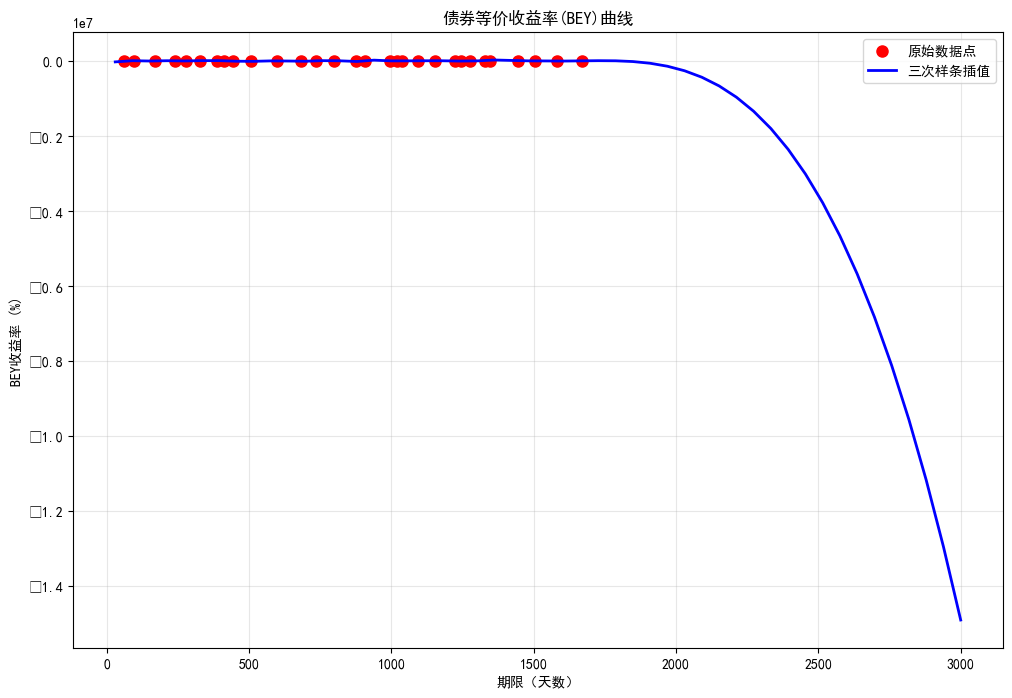

In [26]:

# 7. 绘图展示结果
plt.figure(figsize=(12, 8))

# 子图1: BEY收益率曲线
plt.plot(index, value, 'ro', label='原始数据点', markersize=8)
plt.plot(interp_days, interp_bey * 100, 'b-', label='三次样条插值', linewidth=2)
plt.xlabel('期限（天数）')
plt.ylabel('BEY收益率 (%)')
plt.title('债券等价收益率(BEY)曲线')
plt.grid(True, alpha=0.3)
plt.legend()



